# Experiments for evaluating IRIS

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Data preparation

At the first beginning, we load the reference sequences of the 524 RNAs collected from the [Rfam database](https://rfam.org/) via the [bpRNA interface](http://bprna.cgrb.oregonstate.edu/).

In [2]:
from IRIS.Info_RNA import *
from Bio import SeqIO

all_data = []
for ref_rna in SeqIO.parse('./data/Rfam_H.S._nonsim.fa', 'fasta'):
    all_data.append(Info_RNA(ref_rna.id, ref_rna.seq))
print('--- %d RNA sequences collected' % len(all_data))

--- 524 RNA sequences collected


Then the second step is to load PARIS data. Considering that the raw FASTQ files of PARIS reads are too large, we directly use the resulting BAM files output from [STAR](https://github.com/alexdobin/STAR), which includes the PARIS reads mapped to the 524 RNAs. The PARIS reads are filtered and preprocessed through the codes implemented in [IRIS/Info_PARIS.py](IRIS/Info_PARIS.py).

In [3]:
for rna in all_data:
    rna.PARIS = Info_PARIS('./data/PARIS_reads/split/' + rna.ident + '.bam')

Next, the same-condition icSHAPE data is processed using [icSHAPE pipeline](https://github.com/qczhang/icSHAPE). Here we directly load the processed scores.

In [4]:
icSHAPE_entries = {}
with open('./data/icSHAPE_scores/icSHAPE.out', 'r') as f:
    for line in f:
        ident = line.split('\t')[0]
        icSHAPE_entries[ident] = line.strip()

for rna in all_data:
    if rna.ident in icSHAPE_entries:
        rna.icSHAPE = Info_icSHAPE(icSHAPE_entries[rna.ident])

After loading the PARIS and icSHAPE data. Only the RNAs with more than 1,000 PARIS reads mapped and with valid icSHAPE scores are retained as the test data.

In [5]:
avaliable_data = []
for rna in all_data:
    if len(rna.PARIS.blocks) > 1000 and rna.icSHAPE != None:
        avaliable_data.append(rna)
                              
for i in range(len(avaliable_data)):
    print('%4d: %s' % (i+1, avaliable_data[i].ident))

   1: bpRNA_RFAM_999|RF00004_ABBA01028418.1_3128-3319|U2_spliceosomal_RNA|Rfam||0|192|1|published
   2: bpRNA_RFAM_4778|RF00030_M29212.1_2-265|RNase_MRP|Rfam||0|264|1|published
   3: bpRNA_RFAM_5220|RF00045_L07382.1_2-208|Small_nucleolar_RNA_SNORA73|Rfam||0|207|1|published
   4: bpRNA_RFAM_6402|RF00091_AC099332.2_52634-52482|Small_nucleolar_RNA_SNORA62|Rfam||0|153|1|predicted
   5: bpRNA_RFAM_7522|RF00138_X72205.1_148-246|Small_nucleolar_RNA_SNORD16|Rfam||0|99|1|predicted
   6: bpRNA_RFAM_11528|RF00279_AL357314.11_74156-74234|Small_nucleolar_RNA_SNORD45|Rfam||0|79|1|predicted
   7: bpRNA_RFAM_15094|RF00478_AY077737.1_2-276|Small_Cajal_body_specific_RNA_6|Rfam||0|275|1|published
   8: bpRNA_RFAM_17298|RF00567_AL121585.22_69574-69338|Small_nucleolar_RNA_SNORA35|Rfam||0|237|1|predicted
   9: bpRNA_RFAM_18156|RF00618_U62822.1_2-128|flavivirus_capsid_hairpin_cHP|Rfam||0|127|1|published
  10: bpRNA_RFAM_25079|RF01296_AF308283.1_1-330|Small_nucleolar_RNA|Rfam||0|330|1|predicted
  11: bpRNA_RF

Therefore, we retained 11 RNAs as test data.

The naming rules for RNA identifiers are
> `<bpRNA_id>|<Rfam_id>|<bpRNA_name>|<source>||0|<length>|<strand>|<validation>`

## 2. Performing IRIS and baseline methods

We run IRIS on the test data of the 11 RNAs and predict RNA secondary structure ensembles with 1, 2, and 3 representative structures (denoted as IRIS-1, IRIS-2, and IRIS-3 respectively). We also compute the structure with minimum free energy (denoted as MFE) as an ensemble of only one structure as the baseline.

The parameters for running IRIS vary depending on the length of RNA, as shown below.

In [6]:
def IRIS_parameters(N):
    if N < 160:
        return 100, 0.50, [3, 4, 5, 6]
    elif N >= 160 and N < 300:
        return 100, 0.75, [4, 5, 6, 7]
    else:
        return 100, 0.90, [4, 5, 6, 7]

Here, we run all the methods. This may take a few minutes.

In [7]:
from IRIS.IRIS_Core import *
from IRIS.Baseline_Methods import *

ostream = open('/dev/null', 'w')

predicted_ensembles = {}
for rna in avaliable_data:
    print('=== Predicting %s ===' % rna.ident) 
    predicted_ensembles[rna.ident] = {}

    print('--- Run IRIS (scoring) ...', end = ' ')
    IRIS_scoring = Scoring(rna, ostream)
    IRIS_scoring.compute_PARIS_support()

    print('(generating) ... ', end = ' ')
    IRIS_generating = Generating(rna, IRIS_scoring.PARIS_support, ostream)
    IRIS_generating.generate(*IRIS_parameters(rna.N))

    print('(picking) ...')
    IRIS_picking = Picking(rna, IRIS_scoring.PARIS_support, IRIS_generating.candidate_structures, ostream)

    for K in [1, 2, 3]:
        IRIS_picking.pick(K)
        predicted_ensembles[rna.ident]['IRIS-%d' % K] = IRIS_picking.ensemble

    print('--- Run MFE ...')
    mfe = MFE(rna)
    mfe.predict()
    predicted_ensembles[rna.ident]['MFE'] = mfe.ensemble

    print('=== Finished ===\n')

=== Predicting bpRNA_RFAM_999|RF00004_ABBA01028418.1_3128-3319|U2_spliceosomal_RNA|Rfam||0|192|1|published ===
--- Run IRIS (scoring) ... (generating) ...  (picking) ...
--- Run MFE ...
=== Finished ===

=== Predicting bpRNA_RFAM_4778|RF00030_M29212.1_2-265|RNase_MRP|Rfam||0|264|1|published ===
--- Run IRIS (scoring) ... (generating) ...  (picking) ...
--- Run MFE ...
=== Finished ===

=== Predicting bpRNA_RFAM_5220|RF00045_L07382.1_2-208|Small_nucleolar_RNA_SNORA73|Rfam||0|207|1|published ===
--- Run IRIS (scoring) ... (generating) ...  (picking) ...
--- Run MFE ...
=== Finished ===

=== Predicting bpRNA_RFAM_6402|RF00091_AC099332.2_52634-52482|Small_nucleolar_RNA_SNORA62|Rfam||0|153|1|predicted ===
--- Run IRIS (scoring) ... (generating) ...  (picking) ...
--- Run MFE ...
=== Finished ===

=== Predicting bpRNA_RFAM_7522|RF00138_X72205.1_148-246|Small_nucleolar_RNA_SNORD16|Rfam||0|99|1|predicted ===
--- Run IRIS (scoring) ... (generating) ...  (picking) ...
--- Run MFE ...
=== Finishe

## 3. Evaluation by evolutionary conservation

The ensemble of RNA secondary structures predicted by IRIS is expected to be evolutionarily conserved. Here we retrieve the multiple sequence alignment of homologous sequences in the corresponding RNA family from [Rfam](https://rfam.org/), and then use [R-scape](http://eddylab.org/R-scape/) to compute the normalized mutual information between each pair of bases. The script to run R-scape is [data/Rfam_MSA/run_R-scape.py](data/Rfam_MSA/run_R-scape.py).

In [8]:
for rna in avaliable_data:
    rna.coevolution = Info_Coevolution(rna, './data/Rfam_MSA/sto_files', './data/Rfam_MSA/cov_files')

Then the evaluation by coevolutionary conservation is measured by the KL distance between the base-pairing probability matrix and the normalized mutual information matrix.

In [9]:
from tabulate import tabulate

KL_table_title = 'The KL divergence between the base-pairing probability matrix ' + \
                 'and the normalized mutual information matrix'
KL_table_header = ['Rfam ID', 'Length', 'MFE', 'IRIS-1', 'IRIS-2', 'IRIS-3']
KL_table_content = []
for i in range(len(avaliable_data)):
    rna = avaliable_data[i]
    KL_MFE = rna.coevolution.evaluate_KL_divergence(predicted_ensembles[rna.ident]['MFE'])
    KL_IRIS_1 = rna.coevolution.evaluate_KL_divergence(predicted_ensembles[rna.ident]['IRIS-1'])
    KL_IRIS_2 = rna.coevolution.evaluate_KL_divergence(predicted_ensembles[rna.ident]['IRIS-2'])
    KL_IRIS_3 = rna.coevolution.evaluate_KL_divergence(predicted_ensembles[rna.ident]['IRIS-3'])
    KL_table_content.append([rna.ident.split('|')[1], rna.N, '%.1f' % KL_MFE, 
                             Utils.emphasize(KL_IRIS_1, KL_MFE, '<='), 
                             Utils.emphasize(KL_IRIS_2, KL_MFE, '<='),
                             Utils.emphasize(KL_IRIS_3, KL_MFE, '<=')])
print(KL_table_title)
print(tabulate(KL_table_content, headers = KL_table_header))
print('Note: The \x1b[31mred\x1b[0m scores are the cases that IRIS perform better than MFE.')

The KL divergence between the base-pairing probability matrix and the normalized mutual information matrix
Rfam ID                             Length    MFE    IRIS-1    IRIS-2    IRIS-3
--------------------------------  --------  -----  --------  --------  --------
RF00004_ABBA01028418.1_3128-3319       192  147.7      98.1      98        93
RF00030_M29212.1_2-265                 264  127.9     131        96.1      85.3
RF00045_L07382.1_2-208                 207  218.2     214.4     198.4     195
RF00091_AC099332.2_52634-52482         153  327.1     327.1     320.7     299.6
RF00138_X72205.1_148-246                99  352.5     318.3     315.2     292.3
RF00279_AL357314.11_74156-74234         79  152       156.1     158.4     142.1
RF00478_AY077737.1_2-276               275  494.1     520.7     481.4     470.1
RF00567_AL121585.22_69574-69338        237  385.3     410.9     383.8     366.4
RF00618_U62822.1_2-128                 127   53.5      53.5      52.9      52.6
RF01296_AF308283.

## 4. Evaluation on icSHAPE data

Another effective metric is to check the consistency between IRIS-predicted RNA structure ensembles and icSHAPE data, which is an *in vivo* assay orthogonal to PARIS. The icSHAPE data is processed into a score ranging from 0 to 1 for each base of the RNA, indicating the probability that this base is paired. Thus, to obtain the distribution of icSHAPE scores, we focus on the RNAs whose consensus secondary structure curated by [bpRNA](http://bprna.cgrb.oregonstate.edu/) have been validated by published articles and whose lengths are less than 100 nt as the training data (considering that short, validated RNAs are unlikely to have alternative secondary structures *in vivo*).

In [10]:
icSHAPE_train_data = []
for rna in all_data:
    validation = rna.ident.split('|')[-1]
    if rna.N <= 100 and rna.icSHAPE != None and rna.icSHAPE.rpkm > 1000 and validation == 'published':
        icSHAPE_train_data.append(rna) 
print('--- %d RNA sequences are selected to train icSHAPE score distributions' % len(icSHAPE_train_data))

--- 25 RNA sequences are selected to train icSHAPE score distributions


As shown above, 25 RNAs are retained as the trainning data. Then, we fit these icSHAPE scores to the Beta distributions.

=== Load training data for icSHAPE score distribution ===
--- Collect 25 RNA with curated secondary structure in ./data/bpRNA_annotated_structures
--- 291 paired bases
--- 289 unpaired bases
=== Finished ===


=== Train icSHAPE score distribution ===
--- paired_beta	 (0.1579534781762712, 0.8457051293571116, 0, 1)
--- unpaired_beta	 (0.2089119236254529, 0.3648459100270444, 0, 1)
=== Finished ===




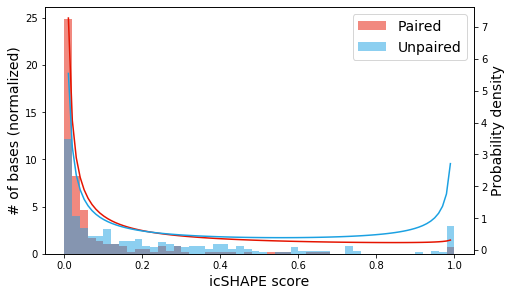

In [11]:
icSHAPE_distribution = Train_icSHAPE_Distribution(icSHAPE_train_data, './data/bpRNA_annotated_structures')
icSHAPE_distribution.learn_parameters()
icSHAPE_distribution.plot_distributions()

Unlike PARIS data, icSHAPE data provide marginal information for base-pairing. As a result, the benchmark for measuring the consistency between the predicted ensemble and icSHAPE data is set as the log-likelihood of observing icSHAPE scores from the predicted ensemble, which is implemented in [IRIS/Info_icSHAPE.py](IRIS/Info_icSHAPE.py).

In [12]:
from tabulate import tabulate

LL_table_title = 'The log-likelihood of observing icSHAPE data ' + \
                 'from the predicted RNA secondary structure ensemble'
LL_table_header = ['Rfam ID', 'MFE', 'IRIS-1', 'IRIS-2', 'IRIS-3']
LL_table_content = []
for i in range(len(avaliable_data)):
    rna = avaliable_data[i]
    LL_MFE = icSHAPE_distribution.compute_log_likelihood(predicted_ensembles[rna.ident]['MFE'])
    LL_IRIS_1 = icSHAPE_distribution.compute_log_likelihood(predicted_ensembles[rna.ident]['IRIS-1'])
    LL_IRIS_2 = icSHAPE_distribution.compute_log_likelihood(predicted_ensembles[rna.ident]['IRIS-2'])
    LL_IRIS_3 = icSHAPE_distribution.compute_log_likelihood(predicted_ensembles[rna.ident]['IRIS-3'])
    LL_table_content.append([rna.ident.split('|')[1], '%.1f' % LL_MFE, 
                             Utils.emphasize(LL_IRIS_1, LL_MFE, '>='), 
                             Utils.emphasize(LL_IRIS_2, LL_MFE, '>='),
                             Utils.emphasize(LL_IRIS_3, LL_MFE, '>=')])
print(LL_table_title)
print(tabulate(LL_table_content, headers = LL_table_header))
print('Note: The \x1b[31mred\x1b[0m scores are the cases that IRIS perform better than MFE.')

The log-likelihood of observing icSHAPE data from the predicted RNA secondary structure ensemble
Rfam ID                             MFE    IRIS-1    IRIS-2    IRIS-3
--------------------------------  -----  --------  --------  --------
RF00004_ABBA01028418.1_3128-3319  551.5     577.2     578.8     579.5
RF00030_M29212.1_2-265            435.4     422.4     450.7     452.1
RF00045_L07382.1_2-208            298.2     298.3     298.1     297.6
RF00091_AC099332.2_52634-52482    176.9     176.9     190.1     187.3
RF00138_X72205.1_148-246          136.4     136.1     135.1     134.7
RF00279_AL357314.11_74156-74234    25.4      40.6      40.6      48.7
RF00478_AY077737.1_2-276          316.3     312.3     319.3     317.7
RF00567_AL121585.22_69574-69338   321.2     322       335.6     335.7
RF00618_U62822.1_2-128            121.4     121.4     120.7     118.9
RF01296_AF308283.1_1-330          468.7     467.4     473.7     473.8
RF02556_ABSL01008103.1_469-355    115       115       120.3    